<h1> Project 2 Embeddings</h1>
<h2>SetUp</h2>
There are different techniques to extract information from raw text data and use it to train a classification model.Let's get required libraries for to start with word embeddings. 

In [1]:
## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for Word2Vec
import gensim.downloader as api
from gensim import models
from gensim.models import KeyedVectors
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial



import warnings
warnings.filterwarnings('ignore')

<h2>Let's read training dataset using pandas library. Create columns to store Event id and Event details as EventId and Event respectively and see how the data looks like.</h2>

In [139]:


f = open('train.json', "r")

data = json.loads(f.read())
#type(data)

df_train = pd.DataFrame.from_dict(data.items())
df_train.columns = ['Event', 'EventId']
df_train

,Event,EventId
0,net lived lofty expectation month basketball l...,16
1,duck time allowing goal game season instance s...,23
2,invezz wednesday november hewlett packard nyse...,24
3,nov photo provided george loegering large spin...,143
4,actress jennifer love hewitt birth baby girl n...,11
...,...,...
5624,bygone damsel distress talking cinderella snow...,19
5625,abu dhabi national day firework programme expa...,20
5626,men woman experience post sex regret wildly re...,71
5627,dim outlook traditional desktop pc day slight ...,24


## Let's get count of events and all the EvenIds grouped together to get the tokenized text for each eventid. 

In [140]:
uniqueVal = df_train.EventId.nunique()
print(uniqueVal)

152


In [141]:
uEvent = pd.unique(df_train['EventId'])
uEvent

array(['16', '23', '24', '143', '11', '79', '117', '14', '3', '101', '48',
       '63', '87', '57', '100', '61', '32', '88', '58', '142', '116',
       '110', '68', '83', '114', '77', '56', '105', '29', '64', '7', '93',
       '75', '99', '66', '18', '40', '102', '130', '36', '67', '104',
       '65', '128', '22', '25', '31', '60', '50', '46', '12', '4', '6',
       '19', '76', '38', '124', '86', '62', '21', '127', '9', '5', '145',
       '44', '123', '15', '47', '2', '129', '35', '115', '41', '94', '33',
       '39', '54', '118', '13', '82', '131', '72', '37', '42', '108',
       '112', '95', '85', '69', '70', '17', '34', '141', '120', '92',
       '78', '49', '80', '10', '89', '43', '137', '109', '59', '84', '97',
       '74', '1', '147', '26', '90', '96', '20', '103', '126', '146',
       '119', '45', '30', '73', '106', '149', '135', '71', '91', '52',
       '133', '28', '113', '8', '98', '53', '122', '121', '132', '125',
       '111', '140', '81', '51', '138', '148', '150', '134', 

In [142]:
df_cnt = df_train.groupby(['EventId'])['EventId'].count()
df_cnt.head(50)

EventId
1      70
10     24
100    25
101    70
102    70
103    17
104    32
105    48
106    22
107     7
108    11
109    40
11     53
110    19
111    12
112     8
113    10
114    37
115     8
116    20
117    19
118     7
119    36
12     70
120    23
121    27
122    15
123    48
124    10
125    15
126    14
127    12
128    31
129    14
13     70
130    21
131    35
132     5
133     9
134    11
135    11
136     2
137    13
138     3
139     3
14     70
140    18
141    16
142    25
143    11
Name: EventId, dtype: int64

In [143]:
df_train = df_train.groupby(['EventId']).agg({'Event': ' '.join})
df_train

,Event
EventId,
1,prince william joined taylor swift jon bon jov...
10,sinn fein positioning mary lou mcdonald party ...
100,los angeles auto year unveiling large number e...
101,washin nov reuters thanksgiving traveler face ...
102,secretary general ban ki moon second round syr...
...,...
95,latvian prime minister valdis dombrovskis resi...
96,common dissolvable medication sa risk heart at...
97,sony corp long time synonym quality electronic...


<h2>Data PreProcessing</h2>

<p> To perform data preprocessing, utils_preprocess_text functions is created. This function will take 3 parameters, flag for stemming, flag for lemmatization and stopwords. This will remove stopwards like a, the, this which we found in almost every documents and in large quantity. So to find actual rare words from document, we will remove these stopwords. This process will convert all chars in lowercase, remove special characters, remove any blank/white spaces, perform lemmatization or stemming which is needed. And output will be stored as text_clean column value. </p>

In [144]:
df_stopwords = nltk.corpus.stopwords.words("english")

In [145]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [146]:
df_train["text_clean"] = df_train["Event"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=df_stopwords))
df_train.head()

,Event,text_clean
EventId,,
1,prince william joined taylor swift jon bon jov...,prince william joined taylor swift jon bon jov...
10,sinn fein positioning mary lou mcdonald party ...,sinn fein positioning mary lou mcdonald party ...
100,los angeles auto year unveiling large number e...,los angeles auto year unveiling large number e...
101,washin nov reuters thanksgiving traveler face ...,washin nov reuters thanksgiving traveler face ...
102,secretary general ban ki moon second round syr...,secretary general ban ki moon second round syr...


<h2>We will now perform the same steps for test data as below.</h2>

In [10]:
f = open('test.json', "r")

data_test = json.loads(f.read())
#type(data)

df_test = pd.DataFrame.from_dict(data_test.items())
df_test.columns = ['Event', 'EventId']
df_test

,Event,EventId
0,mcdonald royal cheese france facing competitio...,43
1,parson missing family dead parson kansa attorn...,74
2,thursday evening nov photo bianca ward scream ...,13
3,pope francis embraced hermeneutic reform pope ...,46
4,washin obama administration proposed rule tues...,38
...,...,...
2826,thanksgiving travel snarled storm lash eastern...,101
2827,east coast bracing snow ice storm threatening ...,101
2828,causing epic thanksgiving storm dip jet stream...,101
2829,daily roundup global report security issue ski...,102


In [11]:
#Total Events
uniqueVal_test = df_test.EventId.nunique()
print(uniqueVal_test)

152


In [12]:
df_test = df_test.groupby(['EventId'], as_index = False).agg({'Event': ' '.join})

In [13]:
df_test["text_clean"] = df_test["Event"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=df_stopwords))
df_test.head()

,EventId,Event,text_clean
0,1,rock roya teamed actual roya night prince will...,rock roya teamed actual roya night prince will...
1,10,liam adam brother sinn gerry adam jailed year ...,liam adam brother sinn gerry adam jailed year ...
2,100,year auto unveiling number electric car early ...,year auto unveiling number electric car early ...
3,101,large storm blamed death west blew oklahoma te...,large storm blamed death west blew oklahoma te...
4,102,beirut reuters syrian authority attend talk ja...,beirut reuters syrian authority attend talk ja...


<h1> TF-IDF </h1>
### Let's start with our baseline model - TF-IDF.
<p>TF-IDF stands for term frequency-inverse document frequency. A simple way to calculate term frequencies is to divide the number of occurrences of a word by the total number of words in the document. In this way, the number of times a word appears in large documents can be compared to that of smaller documents.

However, it may be hard to differentiate documents based on term frequency if a word shows up in a majority of documents. To handle this we also consider *inverse document frequency*, which is the total number of documents divided by the number of documents that contain the word.</p>

In [14]:
df_train.head()

,Event,text_clean
EventId,,
1,prince william joined taylor swift jon bon jov...,prince william joined taylor swift jon bon jov...
10,sinn fein positioning mary lou mcdonald party ...,sinn fein positioning mary lou mcdonald party ...
100,los angeles auto year unveiling large number e...,los angeles auto year unveiling large number e...
101,washin nov reuters thanksgiving traveler face ...,washin nov reuters thanksgiving traveler face ...
102,secretary general ban ki moon second round syr...,secretary general ban ki moon second round syr...


## Future Extraction using TF-IDF
TF-IDFVectorizer is getting used for future extraction from text in the corpus. We can perform word count using CountVectorizer. then compute the Inverse Document Frequency (IDF) values and only then compute the Tf-idf scores. All these steps are getting done at once using TF-IDFVectorizer. 
Tf-Idf vectorizer is gettting used with a limit of 10,000 words for unigram and bigram. We will use the vectorizer on the preprocessed corpus of the train set to extract a vocabulary and create the feature matrix. The feature matrix X_train has a shape of 152 (Number of event details in training) x 10,000 (Length of vocabulary)

In [15]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

corpus = df_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dict_vocabulary = vectorizer.vocabulary_

(152, 10000)

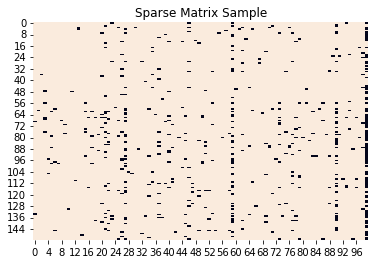

In [16]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')
X_train.shape

Word 'los angeles' is the 5125th feature of the matrix for the given corpus. We can find position of the word as below:

In [17]:
word = 'los angeles'
dict_vocabulary[word]

5125

<h2> Word2Vec </h2>

Let's proceed with our next word embedding approach using Word2Vec. The effectiveness of Word2Vec comes from its ability to group together vectors of similar words.Word2Vec can make strong estimates about a word’s meaning based on their occurrences in the text. These estimates yield word associations with other words in the corpus. 

In [18]:
nlp = api.load("word2vec-google-news-300")

In [19]:
corpus = df_train["text_clean"]

Instead of using a pre-trained model, let's fit our own Word2Vec on the training data corpus with gensim.To do that,  the corpus needs to be transformed into a list of lists of n-grams.

In [20]:
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = models.phrases.Phrases(lst_corpus, delimiter=" ", min_count=5, threshold=10)
bigrams_detector = models.phrases.Phraser(bigrams_detector)

trigrams_detector = models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ", min_count=5, threshold=10)
trigrams_detector = models.phrases.Phraser(trigrams_detector)



Word2Vec can be used two ways - using CBOW or Skip Gram. We are using skip Gram, starting from a single word to predict its context.
Other Parameters Used : target size of the word vector as 300. epochs 30 and min count as 1.

In [21]:
## fit w2v
nlp = models.word2vec.Word2Vec(lst_corpus, vector_size=300, window=8, min_count=1, sg=1, epochs=30)

Now, we can select any word from the corpus and transform it into a vector. We have analyzed vectors for word 'prince' and 'doctor' as below.

In [22]:
word = 'prince'
# Store just the words + their trained embeddings.
word_vectors = nlp.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

vector = nlp.wv[word]  # Get numpy vector of a word
vector.shape

(300,)

 Model generate 300-dimensional word vectors, and all we have to do to create a vector is to pass it through the model. Each vector looks like this:

In [23]:
vector[:20]

array([-0.17920715,  0.11581378,  0.19139923,  0.22260459,  0.1611242 ,
        0.09211816, -0.64953303, -0.01283085,  0.18364856,  0.3663048 ,
       -0.45971456, -0.29638886,  0.1335355 , -0.3889886 ,  0.24520274,
       -0.08817579, -0.23909177,  0.156992  , -0.11572943,  0.677644  ],
      dtype=float32)

<p>Let's visualize a word and its context into a smaller dimensional space and also using PCA, Principal Component Analysis, a statistical concept. We will observe here top 20 similar words for 'prince'.</p>

In [24]:
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in wv.most_similar(word, topn=20)]
X = wv[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

<Figure size 432x288 with 0 Axes>

In [25]:
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

In [26]:
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
dtf_["input"]

prince        1
william       0
swift         0
afters        0
tabloid       0
fodder        0
favourite     0
fore          0
wail          0
dignitary     0
backstage     0
cutie         0
starstruck    0
charmings     0
pulse         0
vaguely       0
lifestyle     0
mingled       0
mingle        0
sings         0
fairytale     0
Name: input, dtype: int64

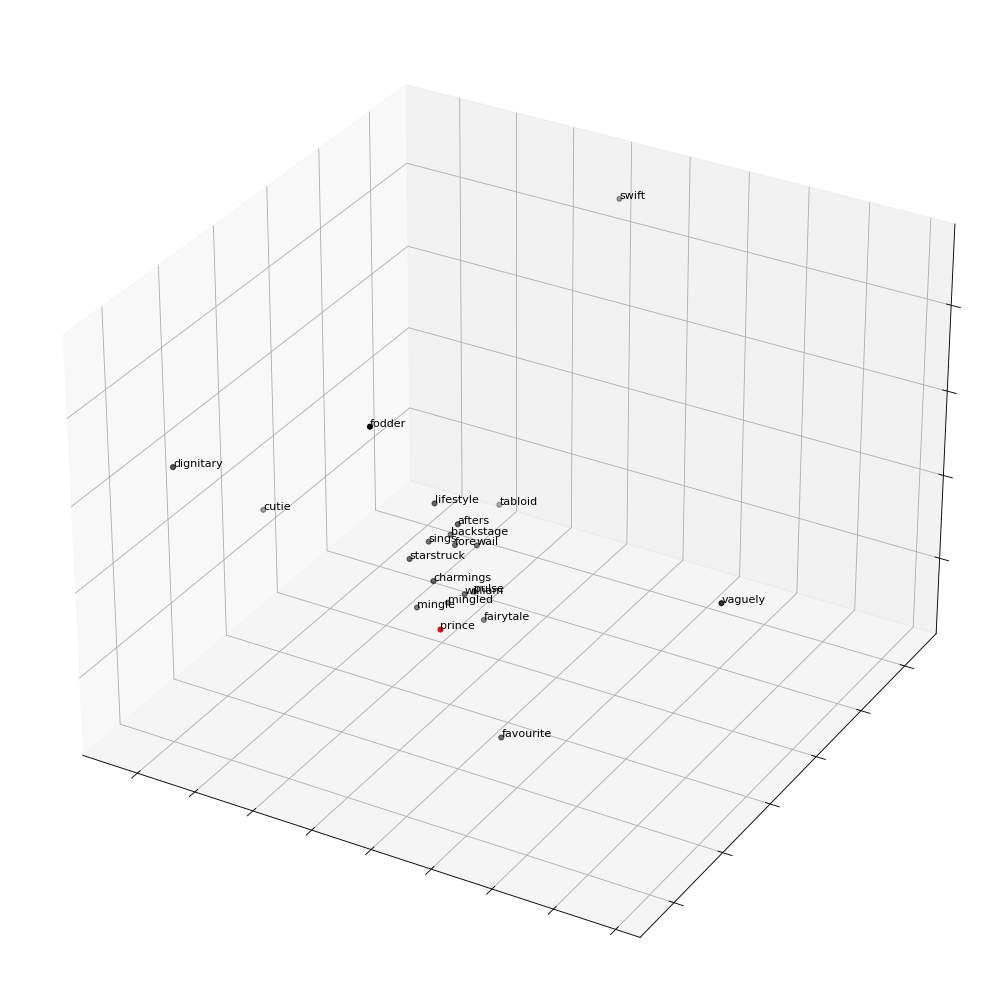

In [27]:
## plot 3d

fig=plt.figure(figsize=(16, 20), dpi=80)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)
plt.show()

In [28]:
word = 'doctor'
# Store just the words + their trained embeddings.
word_vectors = nlp.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

vector = wv[word]  # Get numpy vector of a word
vector.shape

(300,)

In [29]:
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in nlp.wv.most_similar(word, topn=20)]
X = wv[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

<Figure size 432x288 with 0 Axes>

In [30]:
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

In [31]:
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
dtf_["input"]

doctor           1
accurately       0
rely             0
remodeling       0
misdiagnosing    0
drastic          0
organ            0
tga              0
reticence        0
symptom          0
minimally        0
aching           0
reliable         0
invasive         0
nausea           0
diagnosing       0
fainting         0
smu              0
ami              0
cpcs             0
evaluating       0
Name: input, dtype: int64

words of the same context usually appear together in the corpus, so they will be close in the vector space as well. Let's see closer words for word doctor.

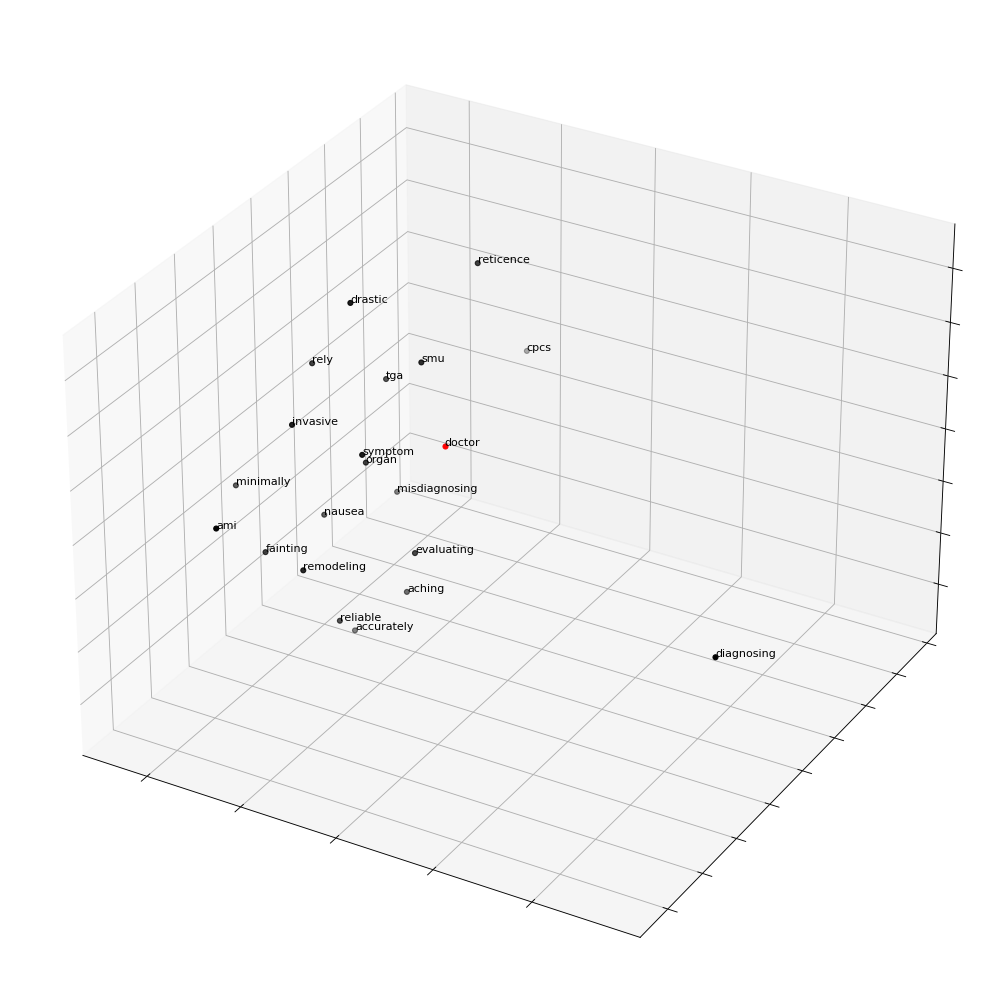

In [32]:
## plot 3d

fig=plt.figure(figsize=(16, 20), dpi=80)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)
plt.show()

In [33]:
nlp.wv.most_similar('doctor')

[('accurately', 0.7069507837295532),
 ('rely', 0.7054293155670166),
 ('remodeling', 0.6954332590103149),
 ('misdiagnosing', 0.6919781565666199),
 ('drastic', 0.6855782270431519),
 ('organ', 0.6808496117591858),
 ('tga', 0.6807075142860413),
 ('reticence', 0.6806683540344238),
 ('symptom', 0.6758934855461121),
 ('minimally', 0.6729491949081421)]

In [34]:
v1 = nlp.wv['doctor']
v2 = nlp.wv['terminator']

Define a function that computes cosine similarity between two words

In [35]:

def cosine_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

In [36]:
cosine_similarity(v1, v2)

0.6281368732452393

As per below, we can observe the most similar word for wonderful is goodwill.

In [37]:
nlp.wv.most_similar('wonderful')

[('goodwill', 0.7510992288589478),
 ('marchese', 0.7018572092056274),
 ('darci', 0.6873044967651367),
 ('graced', 0.6627485156059265),
 ('funnyman', 0.6613364815711975),
 ('wtop', 0.6503225564956665),
 ('anticipation', 0.647483229637146),
 ('mishmash', 0.6391597390174866),
 ('characterized', 0.6370545029640198),
 ('thanksgivuk', 0.6369292140007019)]

<h2> Using Bert </h2>

A same word with different meanings is the big challange for word embedding. This has been overcome by Language Models. Google’s Bidirectional Encoder Representations from Transformers, BERT, combines contextual embedding, several transformers and bidirectional. 

In [38]:
import transformers


Let's see Bert Tokenizer and TFBertModel implementation. Bert performs preprocessing data step implicitly.

In [39]:
txt = "los angeles"

## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
## return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]  
embedding = nlp(input_ids)
embedding[0][0]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[ 1.8074792e-03, -4.4481792e-02, -1.2863439e-01, ...,
        -3.7585366e-01,  2.8275689e-01, -1.8261930e-02],
       [ 6.5991074e-02, -2.8551918e-01, -1.2060338e-01, ...,
        -4.2068851e-01,  4.5877683e-01, -1.3699518e+00],
       [-5.4620743e-01, -9.5824711e-02, -1.1092575e-01, ...,
        -4.1438779e-01, -5.5581594e-01, -2.0355849e+00],
       [ 7.9150450e-01,  6.8231232e-02, -2.5179222e-01, ...,
         8.5514545e-02, -7.6887769e-01, -1.3827649e-01]], dtype=float32)>

Bert uses same length sentences by masking and adding padding. It uses specialized tokens as [CLS] before starting sentence and [SEP] at the end of the sentence, also [PAD] for the additional sentence length. Masking has been done tokens gets created. [PAD] will get token assigned as zero so it will not be a important feature of the sentence and same way [CLS], [SEP] will also have specific 101, 102 token to understand the sentence start and end. 

In [40]:
corpus = df_train["Event"]
maxlen = 50

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
    
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [41]:
i = 0
#print("txt: ", df_train["Event"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

tokenized: ['[CLS]', '[CLS]', 'prince', 'william', 'joined', 'taylor', 'swift', 'jon', 'bon', 'jo', '##vi', 'stage', 'impromptu', 'performance', 'event', 'image', 'courtesy', '[SEP]', '[UNK]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[SEP]']
idx:  [  101   101  3159  2520  2587  4202  9170  6285 14753  8183  5737  2754
 29213  2836  2724  3746 14571   102   100     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0   102]
mask:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
segment:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [42]:
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K


<h2>Distil-BERT</h2>

We will now see the lighter version of language model, Distil-BERT. We will start everything from scratch to implement this. 

The vector BERT assigns to a word is a function of the entire sentence, therefore, a word can have different vectors based on the contexts. We will do transfer learning from a pre-trained lighter version of BERT, called Distil-BERT 

<h2> Lighter version of Bert</h2>

Below we are using hyper parameters as:
<ul>dropout rate = 0.2, </ul>
<ul>activation = relu, </ul>
<ul>Dense layers = 64 </ul>
<ul>Pooling = GlobalAveragePooling1D.</ul>
<ul>loss = sparse_categorical_crossentropy, </ul>
<ul>optimizer = adam </ul>
<ul>metrics = accuracy </ul>

We see trainable parameters are 70,601


In [43]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)

config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]

## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(df_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

<h2>Deep learning model with transfer learning from the pre-trained BERT</h2>

In [44]:
f = open('train.json', "r")

data = json.loads(f.read())
#type(data)

df_train = pd.DataFrame.from_dict(data.items())
df_train.columns = ['Event', 'EventId']

In [45]:
df_train['Event']

0       net lived lofty expectation month basketball l...
1       duck time allowing goal game season instance s...
2       invezz wednesday november hewlett packard nyse...
3       nov photo provided george loegering large spin...
4       actress jennifer love hewitt birth baby girl n...
                              ...                        
5624    bygone damsel distress talking cinderella snow...
5625    abu dhabi national day firework programme expa...
5626    men woman experience post sex regret wildly re...
5627    dim outlook traditional desktop pc day slight ...
5628    investor braced bad news veteran computer firm...
Name: Event, Length: 5629, dtype: object

In [46]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt


# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [47]:
tokenized_text = [tokenizer.convert_tokens_to_ids(["[CLS]"] + text.split(' ')[:511] + ["[SEP]"]) for text in list(df_train['Event'])]
seq = []
for id in tokenized_text:
    seq += [' '.join([str(i) for i in id])]
    

    

In [48]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


# define required arrays to store
tokenized_text_arr = []
indexed_tokens_arr = []
segments_ids_arr = []
#outputs_arr = []
cnt = 1

for text in list(df_train['Event']):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [cnt] * len(tokenized_text)
    tokenized_text_arr += tokenized_text
    indexed_tokens_arr += indexed_tokens
    segments_ids_arr += segments_ids
    cnt = cnt+1
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    outputs = model(tokens_tensor, segments_tensors)
    #outputs_arr += outputs

# Display the words with their indeces.
for tup in zip(tokenized_text_arr[:30], indexed_tokens_arr[:30],  segments_ids_arr[:30]):
    print('{:<12} {:>6,}{:>6,}'.format(tup[0], tup[1],  tup[2]))
    


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[CLS]           101     1
net           5,658     1
lived         2,973     1
loft         19,459     1
##y           2,100     1
expectation  17,626     1
month         3,204     1
basketball    3,455     1
long          2,146     1
shot          2,915     1
team          2,136     1
utilized     12,550     1
expected      3,517     1
bench         6,847     1
player        2,447     1
averaging    14,985     1
minute        3,371     1
[SEP]           102     1
[CLS]           101     2
duck          9,457     2
time          2,051     2
allowing      4,352     2
goal          3,125     2
game          2,208     2
season        2,161     2
instance      6,013     2
season        2,161     2
opener       16,181     2
avalanche    18,846     2
oct          13,323     2


In [49]:
# hidden states for last sentence in the corpus for 
hidden_states = outputs[2]

In [50]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 26
Number of hidden units: 768


In [51]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 26, 768])

In [52]:
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 26, 768])

In [53]:
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([26, 13, 768])

In [54]:
# Stores the token vectors, with shape [26 x 3072]
token_vecs_cat = []

# `token_embeddings` is a [26 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 26 x 3072


In [55]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 26 x 768


In [56]:
for i, token_str in enumerate(tokenized_text_arr):
    if(token_str == 'eye'):
        print (i, token_str)

1407 eye
3195 eye
4497 eye
12087 eye
12112 eye
13749 eye
14869 eye
24081 eye
30998 eye
38784 eye
41468 eye
41563 eye
44689 eye
50741 eye
57814 eye
57972 eye
58643 eye
61807 eye
70901 eye
70955 eye
77547 eye
79597 eye
83369 eye
84222 eye
90179 eye
103719 eye
104221 eye
111328 eye
111862 eye
115773 eye
118163 eye
128314 eye
128686 eye
129542 eye
134013 eye
134014 eye
134277 eye
135705 eye
136132 eye
137324 eye
138186 eye
144731 eye
144736 eye
145384 eye
147873 eye
154409 eye


In [57]:
%%script echo skipping
print('First 5 vector values for each instance of "eye".')
print('')
   
print("eye contact   ", str(token_vecs_sum[1407][:5]))
print("eyewear  ", str(token_vecs_sum[3195][:5]))
print("eye watering   ", str(token_vecs_sum[4497][:5]))
print("eye free   ", str(token_vecs_sum[12087][:5]))
print("eyebrow   ", str(token_vecs_sum[12248][:5]))

Couldn't find program: 'echo'


## Let's see Sentence-Bert Embedding!

In [58]:
!pip install sentence-transformers

In [59]:
from sentence_transformers import SentenceTransformer
# load a pre-trained model
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [60]:
sentences = df_train['Event']
sentence_embeddings = sbert_model.encode(sentences)

In [61]:
sentence_embeddings.shape

(5629, 768)

In [62]:
query = "doctor misdiagnosing woman"
query1 = "doctor better educated"
query_vec = sbert_model.encode([query])[0]
query_vec1 = sbert_model.encode([query1])[0]

In [63]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [64]:
"""
compute the cosine similarity using scipy. 
We will retrieve the similarity values between the sentences and our test query.
"""
# Creating an empty Dictionary
dict = {}
dict1 = {}

for sent in sentences:
    sim = cosine(query_vec, sbert_model.encode([sent])[0])
    sim1 = cosine(query_vec1, sbert_model.encode([sent])[0])
    dict.update({sent : sim})
    dict1.update({sent : sim1})
    #print("Sentence = ", sent, "; similarity = ", sim)
    
#print(dict)

In [65]:
max_key = max(dict, key=dict.get)

max_keys = [key for key, value in dict.items() if value == max(dict.values())]

In [66]:
print(max_key)

study woman risk dying heart attack men researcher linked doctor misdiagnosing symptom gender difference identifying symptom photo creative common flickr


In [67]:
max_value = max(dict.values())
print(max_value)

0.7042099


In [68]:
max_key1 = max(dict1, key=dict1.get)
print(max_key1)

housing market better expected economics nutshell rising price increasing builder activity point housing market better expected housing market better expected comment ap photo nam huh


In [69]:
max_value1 = max(dict1.values())
print(max_value1)

0.552011


Let's see top-5 results we got for test data. 

In [70]:
value_key_pairs = ((value, key) for (key,value) in dict.items())
sorted_value_key_pairs = sorted(value_key_pairs, reverse=True)
sorted_value_key_pairs[0:5]

[(0.7042099,
  'study woman risk dying heart attack men researcher linked doctor misdiagnosing symptom gender difference identifying symptom photo creative common flickr'),
 (0.6993096,
  'longview tx nurse died stabbing attack east texas hospital people sustained injury reported associated press ap suspect attack ambulatory surgical center good shepherd medical center'),
 (0.69073385,
  'longview texas nurse died protect patient stabbing texas medical center tuesday hospital official suspect son patient injured people good shepherd ambulatory surgical center'),
 (0.67743355,
  'longview texas nov upi nurse stabbed death tuesday people wounded attack hospital longview texas authority suspect attack good shepherd medical center kyron raushaun'),
 (0.67452097,
  'male suspect custody identity released time emergency room accepting patient fox headlinesmore breaking family recount stabbing inside longview hospital nurse dy injured')]

In [71]:
value_key_pairs = ((value, key) for (key,value) in dict1.items())
sorted_value_key_pairs = sorted(value_key_pairs, reverse=True)
sorted_value_key_pairs[0:5]

[(0.552011,
  'housing market better expected economics nutshell rising price increasing builder activity point housing market better expected housing market better expected comment ap photo nam huh'),
 (0.5435488,
  'good news modern medicine advance faster pace government bad news regulator eventually catch cue food drug administration bidding emerging field personal'),
 (0.51328915,
  'patient effervescent dispersible soluble medicine sodium greater risk cardiovascular event compared patient effervescent dispersible soluble version ame drug find study'),
 (0.51052207,
  'independent scotland share pound rest uk alex salmond today despite government opposition common currency promised country simpler tax system cheaper corporation tax free'),
 (0.5104454,
  'contrary popular belief black friday best day buy list day offer better deal specific kind thing category cheapest day')]

## Doc2Vec

In [168]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kar_d\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [169]:
# Tokenization of each document
tokenized_sent = []

for s in list(df_train['text_clean']):
    tokenized_sent.append(word_tokenize(s.lower()))
#print(tokenized_sent)

In [170]:
# import
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]
#tagged_data

Let's train the model with the parameters:

In [171]:
## Train doc2vec model
modelDoc = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)


In [172]:
test_doc = word_tokenize("doctor misdiagnosing woman symptom")
test_doc_vector = modelDoc.infer_vector(test_doc)
modelDoc.docvecs.most_similar(positive = [test_doc_vector])


[(127, 0.8608024716377258),
 (16, 0.7996811270713806),
 (58, 0.7663881778717041),
 (41, 0.7448992729187012),
 (81, 0.744490385055542),
 (150, 0.7325569987297058),
 (132, 0.7277800440788269),
 (136, 0.7062528729438782),
 (29, 0.7013157606124878),
 (148, 0.6913548707962036)]

In [173]:
similar_documents = modelDoc.docvecs.most_similar([test_doc_vector], topn = 5)
similar_documents

[(127, 0.8608024716377258),
 (16, 0.7996811270713806),
 (58, 0.7663881778717041),
 (41, 0.7448992729187012),
 (81, 0.744490385055542)]

In [174]:
tagged_data[127]

TaggedDocument(words=['difference', 'heart', 'attack', 'pain', 'men', 'woman', 'debunking', 'long', 'held', 'notion', 'ruled', 'heart', 'attack', 'symptom', 'woman', 'men', 'finding', 'study', 'exactly', 'case', 'finding', 'critical', 'care', 'type', 'pain', 'help', 'ing', 'mi', 'woman', 'published', 'nov', 'shalmali', 'pal', 'contributing', 'editor', 'medpage', 'today', 'reviewed', 'zalman', 'agus', 'md', 'emeritus', 'professor', 'perelman', 'school', 'medicine', 'university', 'pennsylvania', 'gay', 'prosser', 'blamed', 'vomiting', 'pain', 'middle', 'chest', 'previous', 'injury', 'consider', 'candidate', 'heart', 'problem', 'fact', 'prosser', 'year', 'middle', 'school', 'mom', 'time', 'dropped', 'hea', 'hday', 'news', 'small', 'difference', 'observed', 'sex', 'specific', 'diagnostic', 'performance', 'chest', 'pain', 'characteristic', 'cpcs', 'diagnosing', 'acute', 'myocardial', 'infarction', 'ami', 'study', 'published', 'online', 'nov', 'jama', 'internal', 'medicine', 'monday', 'nov',

In [175]:
tagged_data[16]

TaggedDocument(words=['breast', 'cancer', 'screening', 'extended', 'younger', 'woman', 'study', 'breast', 'cancer', 'screening', 'extended', 'younger', 'woman', 'decline', 'witnessed', 'breast', 'cancer', 'mortality', 'rate', 'number', 'organization', 'american', 'woman', 'member', 'family', 'brca', 'mutation', 'test', 'negative', 'family', 'specific', 'brca', 'mutation', 'greater', 'risk', 'developing', 'breast', 'cancer', 'compared', 'woman', 'general', 'population', 'study', 'published', 'wednesday', 'nov', 'hea', 'hday', 'news', 'woman', 'family', 'history', 'breast', 'cancer', 'tested', 'brca', 'brca', 'genetic', 'mutation', 'linked', 'disease', 'study', 'suggests', 'woman', 'test', 'negative', 'kfar', 'saba', 'israel', 'tested', 'positive', 'defective', 'gene', 'breast', 'cancer', 'tamar', 'modiano', 'harbored', 'mother', 'fear', 'passed', 'daughter', 'modiano', 'breast', 'removed', 'prevent', 'qi', 'male', 'friend', 'mine', 'breast', 'cancer', 'thought', 'joking', 'joke', 'maste

In [176]:
tagged_data[58]

TaggedDocument(words=['doctor', 'minimally', 'invasive', 'surgical', 'procedure', 'unexpected', 'side', 'weight', 'loss', 'flickr', 'creative', 'common', 'tobyotter', 'current', 'weight', 'loss', 'surgery', 'technique', 'drastic', 'organ', 'remodeling', 'affair', 'doctor', 'reduces', 'patient', 'stomach', 'left', 'gastric', 'artery', 'embolization', 'improves', 'weight', 'loss', 'patient', 'upper', 'bleeding', 'treated', 'transarterial', 'embolization', 'study', 'presented', 'advance', 'annual', 'meeting', 'radiological', 'society', 'north', 'america', 'study', 'report', 'individual', 'underwent', 'embolization', 'left', 'gastric', 'artery', 'bleeding', 'experienced', 'percent', 'decrease', 'body', 'weight', 'three', 'month', 'procedure', 'study', 'offer', 'potential'], tags=[58])

In [177]:
tagged_data[41]

TaggedDocument(words=['analysis', 'indicates', 'prevalence', 'undiagnosed', 'human', 'virus', 'hiv', 'infection', 'state', 'prison', 'entrant', 'north', 'carolina', 'low', 'percent', 'study', 'appearing', 'november', 'issue', 'jama', 'substantial', 'hiv', 'aid', 'hiv', 'screening', 'inmate', 'low', 'yield', 'published', 'nov', 'michael', 'smith', 'north', 'american', 'correspondent', 'medpage', 'today', 'save', 'posttest', 'screening', 'hiv', 'people', 'entering', 'prison', 'system', 'pick'], tags=[41])

## Let's apply Doc2Vec for ungrouped data

In [179]:

f = open('train.json', "r")

data = json.loads(f.read())
#type(data)

data = pd.DataFrame.from_dict(data.items())
data.columns = ['Event', 'EventId']
data

,Event,EventId
0,net lived lofty expectation month basketball l...,16
1,duck time allowing goal game season instance s...,23
2,invezz wednesday november hewlett packard nyse...,24
3,nov photo provided george loegering large spin...,143
4,actress jennifer love hewitt birth baby girl n...,11
...,...,...
5624,bygone damsel distress talking cinderella snow...,19
5625,abu dhabi national day firework programme expa...,20
5626,men woman experience post sex regret wildly re...,71
5627,dim outlook traditional desktop pc day slight ...,24


In [180]:
data["text"] = data["Event"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=df_stopwords))
data.head()

,Event,EventId,text
0,net lived lofty expectation month basketball l...,16,net lived lofty expectation month basketball l...
1,duck time allowing goal game season instance s...,23,duck time allowing goal game season instance s...
2,invezz wednesday november hewlett packard nyse...,24,invezz wednesday november hewlett packard nyse...
3,nov photo provided george loegering large spin...,143,nov photo provided george loegering large spin...
4,actress jennifer love hewitt birth baby girl n...,11,actress jennifer love hewitt birth baby girl n...


Now, we will apply doc2vec model for ungrouped data

In [181]:
# Tokenization of each document
tokenized_sent = []

for s in list(data['text']):
    tokenized_sent.append(word_tokenize(s.lower()))
    
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]

## Train doc2vec model
modelDoc = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

test_doc = word_tokenize("doctor misdiagnosing woman symptom")
test_doc_vector = modelDoc.infer_vector(test_doc)
modelDoc.docvecs.most_similar(positive = [test_doc_vector])

similar_documents = modelDoc.docvecs.most_similar([test_doc_vector], topn = 20)
similar_documents

[(3491, 0.8439211249351501),
 (2831, 0.8423823714256287),
 (3034, 0.8367025256156921),
 (1682, 0.8226330876350403),
 (1750, 0.8201563358306885),
 (2535, 0.8194383978843689),
 (1917, 0.8045675158500671),
 (1508, 0.8037928342819214),
 (2587, 0.8014112710952759),
 (1782, 0.7959815263748169),
 (391, 0.7949185371398926),
 (1001, 0.7946001291275024),
 (1485, 0.7942500710487366),
 (3840, 0.789264976978302),
 (4386, 0.7884699106216431),
 (29, 0.7883549928665161),
 (311, 0.7874529957771301),
 (4439, 0.7861257195472717),
 (5389, 0.7799458503723145),
 (1064, 0.7791422009468079)]

## Let's verify top 20 results for DOC2VEC 

In [241]:


for s in similar_documents:
    i = s[0]
    print(tagged_data[i])


TaggedDocument<['longview', 'texas', 'nurse', 'died', 'protect', 'patient', 'stabbing', 'texas', 'medical', 'center', 'tuesday', 'hospital', 'official', 'suspect', 'son', 'patient', 'injured', 'people', 'good', 'shepherd', 'ambulatory', 'surgical', 'center'], [3491]>
TaggedDocument<['providence', 'brown', 'university', 'researcher', 'brown', 'university', 'banner', 'alzheimer', 'institute', 'infant', 'carry', 'gene', 'associated', 'increased', 'risk', 'alzheimer', 'disease', 'tend', 'difference', 'brain', 'development'], [2831]>
TaggedDocument<['kim', 'kardashian', 'reacts', 'seth', 'rogan', 'james', 'franco', 'spoof', 'kanye', 'west', 'video', 'bound'], [3034]>
TaggedDocument<['monday', 'nov', 'hea', 'hday', 'news', 'chest', 'pain', 'symptom', 'doctor', 'accurately', 'diagnose', 'woman', 'suffering', 'major', 'heart', 'attack', 'survey', 'woman', 'men', 'woman', 'tend'], [1682]>
TaggedDocument<['copyright', 'scripps', 'medium', 'reserved', 'material', 'published', 'broadcast', 'rewrit

## Doc2Vec for test data 

In [243]:
tokenized_sent = []

for s in list(df_test['text_clean']):
    tokenized_sent.append(word_tokenize(s.lower()))
    
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]

## Train doc2vec model
modelDoc = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

test_doc = word_tokenize("doctor misdiagnosing woman symptom")
test_doc_vector = modelDoc.infer_vector(test_doc)
modelDoc.docvecs.most_similar(positive = [test_doc_vector])

similar_documents = modelDoc.docvecs.most_similar([test_doc_vector], topn = 20)
similar_documents
    


[(127, 0.868132472038269),
 (16, 0.8435537219047546),
 (121, 0.8381454944610596),
 (29, 0.81471848487854),
 (58, 0.7682538032531738),
 (123, 0.7675898671150208),
 (103, 0.7491398453712463),
 (39, 0.7443177103996277),
 (41, 0.7126840353012085),
 (27, 0.7004114985466003),
 (150, 0.6873464584350586),
 (148, 0.6856511235237122),
 (18, 0.6847544312477112),
 (124, 0.6811977028846741),
 (44, 0.6651628613471985),
 (55, 0.6619076132774353),
 (31, 0.6524898409843445),
 (20, 0.6431781053543091),
 (26, 0.6413824558258057),
 (73, 0.6388325095176697)]

In [275]:
similar_documents = modelDoc.docvecs.most_similar([test_doc_vector], topn = 5)
similar_documents

[(127, 0.868132472038269),
 (16, 0.8435537219047546),
 (121, 0.8381454944610596),
 (29, 0.81471848487854),
 (58, 0.7682538032531738)]

In [276]:
for s in similar_documents:
    i = s[0]
    print(tagged_data[i])

TaggedDocument<['doctor', 'misdiagnosing', 'woman', 'chest', 'pain', 'heart', 'attack', 'symptom', 'men', 'experience', 'female', 'dying', 'reason', 'happening', 'study', 'jama', 'international', 'medicine', 'compared', 'men', 'woman', 'suffer', 'chest', 'pain', 'acute', 'syndrome', 'chest', 'pain', 'symptom', 'ac', 'situation', 'nadia', 'khan', 'team', 'doctor', 'better', 'educated', 'risk', 'fatal', 'heart', 'attack', 'woman', 'decade', 'recognize', 'warning', 'sign', 'chest', 'pain', 'differently', 'woman', 'men', 'crushing', 'chest', 'chicago', 'il', 'analysis', 'chest', 'pain', 'symptom', 'men', 'woman', 'presenting', 'ami', 'european', 'emergency', 'department', 'indicates', 'good', 'clue', 'specific', 'woman', 'help', 'staff', 'identify', 'woman', 'men', 'alike', 'feel', 'heart', 'attack', 'kind', 'chest', 'pain', 'heart', 'attack', 'symptom', 'differ', 'chest', 'pain', 'pretty', 'standard', 'large', 'study', 'sign', 'heart', 'attack', 'woman', 'men', 'case', 'chest', 'pain', 'r

## Universal Sentence Encoder

In [295]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
modelUnv = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [296]:
sentence_embeddings = modelUnv(df_train['Event'])
query = "doctor misdiagnosing woman symptom"
query_vec = modelUnv([query])[0]

In [297]:
dicUniv = {}

for sent in df_test['Event']:
  sim = cosine(query_vec, modelUnv([sent])[0])
  dicUniv.update({sent : sim})
  #print("Sentence = ", sent, "; similarity = ", sim)
    

In [300]:
max_key = max(dicUniv, key=dicUniv.get)
max_keys = [key for key, value in dicUniv.items() if value == max(dicUniv.values())]
print(max_key)


doctor misdiagnosing woman chest pain heart attack symptom men experience female dying reason happening study jama international medicine compared men woman suffer chest pain acute syndrome chest pain symptom ac situation nadia khan team doctor better educated risk fatal heart attack woman decade recognize warning sign chest pain differently woman men crushing chest chicago il analysis chest pain symptom men woman presenting ami european emergency department indicates good clue specific woman help staff identify woman men alike feel heart attack kind chest pain heart attack symptom differ chest pain pretty standard large study sign heart attack woman men case chest pain reveals european study symptom chest pain experienced woman men awareness heart save washin post dot complicated untangling wired life randi zuckerberg hea science news hea insurance exchange year medical community grown increasingly concerned woman heart attack receive prompt effective treatment difference sex presenta

In [301]:
max_value = max(dicUniv.values())
print(max_value)


0.30162203


In [302]:

value_key_pairs = ((value, key) for (key,value) in dicUniv.items())
sorted_value_key_pairs = sorted(value_key_pairs, reverse=True)
sorted_value_key_pairs[0:5]

[(0.30162203,
  'doctor misdiagnosing woman chest pain heart attack symptom men experience female dying reason happening study jama international medicine compared men woman suffer chest pain acute syndrome chest pain symptom ac situation nadia khan team doctor better educated risk fatal heart attack woman decade recognize warning sign chest pain differently woman men crushing chest chicago il analysis chest pain symptom men woman presenting ami european emergency department indicates good clue specific woman help staff identify woman men alike feel heart attack kind chest pain heart attack symptom differ chest pain pretty standard large study sign heart attack woman men case chest pain reveals european study symptom chest pain experienced woman men awareness heart save washin post dot complicated untangling wired life randi zuckerberg hea science news hea insurance exchange year medical community grown increasingly concerned woman heart attack receive prompt effective treatment differ